In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import plotly as ply
import sklearn as skl
import datetime as dt 
import math
import random

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

In [6]:
# load data 
df = pd.read_csv("books.csv")

# 1. data processing
- 'num_pages' spaces eliminated
- insert 'english' dummy feature, generated from 'language_code', represents by english or other languages

In [7]:
# num_pages space canceled
df = df.rename(columns= {"  num_pages": "num_pages"})

In [8]:
# English dummies
df['english'] = np.where(df['language_code'].str[0:2] == 'en', 1, 0)

In [9]:
cols_adjust = df.columns.tolist()
cols_adjust

['bookID',
 'title',
 'authors',
 'average_rating',
 'isbn',
 'isbn13',
 'language_code',
 'num_pages',
 'ratings_count',
 'text_reviews_count',
 'publication_date',
 'publisher',
 'english']

/var/folders/dz/3jfgccdn52ggwvy9spwly7y00000gn/T/ipykernel_23970/682619250.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['average_rating'],bins=20, color='red')


AttributeError: module 'matplotlib' has no attribute 'title'

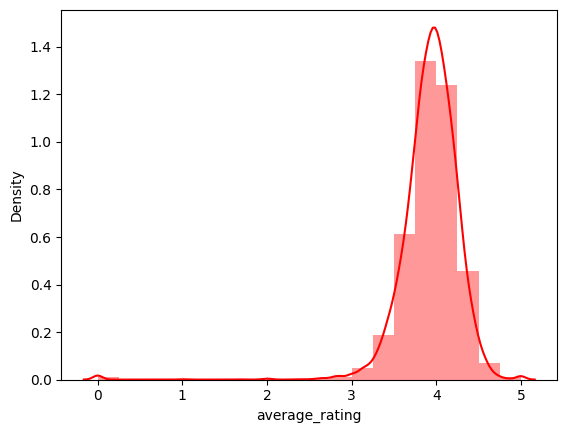

In [10]:
sns.distplot(df['average_rating'],bins=20, color='red')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.show()

# 2. round the value of 'average_rating' into quartile and decile 
### 2.1. generate two functions

In [11]:
# having discrete number of ratings 
def round_to_increment_25(number):
    '''Return the string version of the target rounded in .25% increments'''
    rounded_number = round(number / 0.25) * 0.25
    if 3.5 <= rounded_number and rounded_number <= 4.5:
        return str(rounded_number)
    else:
        if rounded_number > 4.5:
            return str(4.5)
        else:
            return str(1)
        
def round_to_increment_10(number):
    '''Return the string version of the target rounded in .1% increments'''
    rounded_number = round(number, 1)
    if 3.5 <= rounded_number and rounded_number <= 4.5:
        return str(rounded_number)
    else:
        if rounded_number > 4.5:
            return str(4.5)
        else:
            return str(1)

### 2.2. duplicate 2 dfs to adopt the changes

In [12]:
# original distribution of 'average_rating'
df['average_rating'].value_counts()

4.00    219
3.96    195
4.02    178
3.94    176
4.07    172
       ... 
4.91      1
3.10      1
3.03      1
2.99      1
2.33      1
Name: average_rating, Length: 209, dtype: int64

In [13]:
df_a = df.copy()
df_b = df.copy()

In [14]:
df_a['average_rating'] = df_a['average_rating'].apply(round_to_increment_25) # [1, 3.5, 3.75, 4, 4.25, 4.5]


In [15]:
df_b['average_rating'] = df_b['average_rating'].apply(round_to_increment_10) # [1, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5]

In [16]:
df_a['average_rating'].value_counts()

4.0     4000
3.75    2792
4.25    2336
3.5     1022
4.5      589
1        388
Name: average_rating, dtype: int64

In [17]:
df_b['average_rating'].value_counts()

4.0    1824
3.9    1573
3.8    1329
4.1    1318
4.2    1249
3.7     826
4.3     704
3.6     609
1       578
3.5     428
4.4     355
4.5     334
Name: average_rating, dtype: int64

# 3. model testing preparation
### 3.1. setting up R-squared and RMSE indices generating function

In [18]:
def model_cross_val(models={}, X_test=None, y_test=None, cv=None, scoring=()):
    scoring_method = ('r2', 'neg_root_mean_squared_error')

    table = {"r2": [], "neg_root_mean_squared_error": []}

    for mod in models:
        for sco in scoring_method:
            score = cross_val_score(models[mod], X_test, y_test, cv=cv, scoring=sco).mean()
            if sco == 'r2':
                table[sco].append(score)
            else:
                table[sco].append(abs(score))

    print(
        pd.DataFrame(data = table, index = models, columns=table.keys())
        .sort_values(by=list(table.keys())[0], ascending=False)
    )

### 3.2. setting up model selecting generator function

In [19]:
def model_selecting_generator(df=None):
    train0, test = train_test_split(df, test_size=20, random_state=42)

    # split train0 in train and valid
    train, valid = train_test_split(train0, test_size=40, random_state=42)

    # subsetting
    # train0
    X_train0 = train0.drop("average_rating", axis = 1)
    y_train0 = train0.average_rating

    # train
    X_train = train.drop("average_rating", axis = 1)
    y_train = train.average_rating

    # valid
    X_valid = valid.drop("average_rating", axis = 1)
    y_valid = valid.average_rating

    # test
    X_test = test.drop("average_rating", axis = 1)
    y_test = test.average_rating


    ## model selection process
    # Linear Regression
    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)

    # ridge model
    reg_ridge = linear_model.Ridge(alpha=0.01)
    reg_ridge.fit(X_train,y_train)

    # ridge CV
    reg_ridge_CV = linear_model.RidgeCV(alphas=[0.001,0.01,0.1,1,10],cv=5)
    reg_ridge_CV.fit(X_train0,y_train0)

    # lasso model
    reg_lasso = linear_model.Lasso(alpha=0.5)
    reg_lasso.fit(X_train,y_train)

    # random forest
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    rf.fit(X_train, y_train)

    ## R2 + RMSE table
    models = {
        'linear reg': reg, 
        'ridge model': reg_ridge,
        'lasso model': reg_lasso,
        'ridge CV': reg_ridge_CV,
        'random forest': rf
    }

    return model_cross_val(models, X_test, y_test, cv=10)

### 3.3. setting data frame input automates

In [20]:
'''def many_df(df_list):
    for i in range(len(df_list)):
        print(df_list[i].columns.tolist())
        model_selecting_generator(df_list[i])
        print("--- \n")
'''

In [51]:
def many_df(df_list):
    for i in df_list:
        print(f"{i}: {df_list[i].columns.tolist()} \n")
        model_selecting_generator(df_list[i])
        print("--- \n")

### 3.4. index of data frames - part 2

In [42]:
# 4.1. feature engineering: none
df2_0 = df[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count']]

df2_1 = df[['average_rating', 'num_pages', 'text_reviews_count']]
df2_2 = df[['average_rating', 'num_pages', 'ratings_count']]
df2_3 = df[['average_rating', 'ratings_count', 'text_reviews_count']]

df2_4 = df[['average_rating', 'num_pages']]
df2_5 = df[['average_rating', 'text_reviews_count']]
df2_6 = df[['average_rating', 'ratings_count']]
#df2_x = [df2_0, df2_1, df2_2, df2_3, df2_4, df2_5, df2_6]
df2_x = {"df2_0": df2_0, "df2_1": df2_1, "df2_2":df2_2, "df2_3":df2_3, "df2_4":df2_4, "df2_5":df2_5, "df2_6":df2_6}


# 4.2. feature engineering: english dummies
df2_10 = df[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english']]

df2_11 = df[['average_rating', 'num_pages', 'text_reviews_count', 'english']]
df2_12 = df[['average_rating', 'ratings_count', 'num_pages', 'english']]
df2_13 = df[['average_rating', 'ratings_count', 'text_reviews_count', 'english']]

df2_14 = df[['average_rating', 'num_pages', 'english']]
df2_15 = df[['average_rating', 'text_reviews_count', 'english']]
df2_16 = df[['average_rating', 'ratings_count', 'english']]
#df2_1x = [df2_10, df2_11, df2_12, df2_13, df2_14, df2_15, df2_16]
df2_1x = {"df2_10":df2_10, "df2_11":df2_11, "df2_12":df2_12, "df2_13":df2_13, "df2_14":df2_14, "df2_15":df2_15, "df2_16":df2_16}


# 4.3. feature engineering: quartile 'average_rating'
df3_0 = df_a[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count']]

df3_1 = df_a[['average_rating', 'num_pages', 'text_reviews_count']]
df3_2 = df_a[['average_rating', 'num_pages', 'ratings_count']]
df3_3 = df_a[['average_rating', 'ratings_count', 'text_reviews_count']]

df3_4 = df_a[['average_rating', 'num_pages']]
df3_5 = df_a[['average_rating', 'text_reviews_count']]
df3_6 = df_a[['average_rating', 'ratings_count']]
#df3_x = [df3_0, df3_1, df3_2, df3_3, df3_4, df3_5, df3_6]
df3_x = {"df3_0":df3_0, "df3_1":df3_1, "df3_2":df3_2, "df3_3":df3_3, "df3_4":df3_4, "df3_5":df3_5, "df3_6":df3_6}


# 4.4. feature engineering: english dummies, quartile 'average_rating'
df3_10 = df_a[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english']]

df3_11 = df_a[['average_rating', 'num_pages', 'text_reviews_count', 'english']]
df3_12 = df_a[['average_rating', 'ratings_count', 'num_pages', 'english']]
df3_13 = df_a[['average_rating', 'ratings_count', 'text_reviews_count', 'english']]

df3_14 = df_a[['average_rating', 'num_pages', 'english']]
df3_15 = df_a[['average_rating', 'text_reviews_count', 'english']]
df3_16 = df_a[['average_rating', 'ratings_count', 'english']]
#df3_1x = [df3_10, df3_11, df3_12, df3_13, df3_14, df3_15, df3_16]
df3_1x = {"df3_10":df3_10, "df3_11":df3_11, "df3_12":df3_12, "df3_13":df3_13, "df3_14":df3_14, "df3_15":df3_15, "df3_16":df3_16}


# 4.5. feature engineering: decile 'average_rating'
df4_0 = df_b[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count']]

df4_1 = df_b[['average_rating', 'num_pages', 'text_reviews_count']]
df4_2 = df_b[['average_rating', 'num_pages', 'ratings_count']]
df4_3 = df_b[['average_rating', 'ratings_count', 'text_reviews_count']]

df4_4 = df_b[['average_rating', 'num_pages']]
df4_5 = df_b[['average_rating', 'text_reviews_count']]
df4_6 = df_b[['average_rating', 'ratings_count']]
#df4_x = [df4_0, df4_1, df4_2, df4_3, df4_4, df4_5, df4_6]
df4_x = {"df4_0":df4_0, "df4_1":df4_1, "df4_2":df4_2, "df4_3":df4_3, "df4_4":df4_4, "df4_5":df4_5, "df4_6":df4_6}


# 4.6. feature engineering: english dummies, decile 'average_rating'
df4_10 = df_b[['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english']]

df4_11 = df_b[['average_rating', 'num_pages', 'text_reviews_count', 'english']]
df4_12 = df_b[['average_rating', 'ratings_count', 'num_pages', 'english']]
df4_13 = df_b[['average_rating', 'ratings_count', 'text_reviews_count', 'english']]

df4_14 = df_b[['average_rating', 'num_pages', 'english']]
df4_15 = df_b[['average_rating', 'text_reviews_count', 'english']]
df4_16 = df_b[['average_rating', 'ratings_count', 'english']]
#df4_1x = [df4_10, df4_11, df4_12, df4_13, df4_14, df4_15, df4_16]
df4_1x = {"df4_10":df4_10, "df4_11":df4_11, "df4_12":df4_12, "df4_13":df4_13, "df4_14":df4_14, "df4_15":df4_15, "df4_16":df4_16}



# 4. model testing - numeric variables

### 4.1. feature engineering: none
df2_0 - df2_6

In [356]:
many_df(df2_x)

['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count']
                     r2  neg_root_mean_squared_error
lasso model   -1.368071                     0.169600
ridge CV      -2.063746                     0.181474
ridge model   -2.066523                     0.181517
linear reg    -2.066526                     0.181517
random forest -4.580882                     0.184104
---
 
['average_rating', 'num_pages', 'text_reviews_count']
                     r2  neg_root_mean_squared_error
random forest -1.610271                     0.166806
lasso model   -2.502406                     0.180121
ridge CV      -2.591104                     0.181346
ridge model   -2.591114                     0.181346
linear reg    -2.591114                     0.181346
---
 
['average_rating', 'num_pages', 'ratings_count']
                     r2  neg_root_mean_squared_error
linear reg    -2.613689                     0.180322
ridge model   -2.613689                     0.180322
ridge CV      -2.61

### 4.2. feature engineering: english dummies
df2_10 - df2_16

In [351]:
many_df(df2_1x)

['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english']
                     r2  neg_root_mean_squared_error
lasso model   -1.368071                     0.169600
ridge model   -3.422697                     0.178487
linear reg    -3.434876                     0.178518
ridge CV      -3.482528                     0.179340
random forest -4.609585                     0.180090
---
 
['average_rating', 'num_pages', 'text_reviews_count', 'english']
                     r2  neg_root_mean_squared_error
random forest -2.259819                     0.172226
lasso model   -2.502406                     0.180121
ridge CV      -2.888840                     0.175594
ridge model   -4.392116                     0.178037
linear reg    -4.405216                     0.178066
---
 
['average_rating', 'ratings_count', 'num_pages', 'english']
                     r2  neg_root_mean_squared_error
lasso model   -2.622480                     0.180983
ridge CV      -2.966749                

### 4.3. feature engineering: quartile 'average_rating'
df3_0 - df3_6

In [54]:
many_df(df3_x)

df3_0: ['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count'] 

                     r2  neg_root_mean_squared_error
lasso model    0.000836                     0.181932
random forest -0.045738                     0.180565
ridge CV      -0.052686                     0.194029
ridge model   -0.052973                     0.194074
linear reg    -0.052973                     0.194074
--- 

df3_1: ['average_rating', 'num_pages', 'text_reviews_count'] 

                     r2  neg_root_mean_squared_error
random forest  0.096277                     0.173498
lasso model   -0.001450                     0.175210
ridge CV      -0.004228                     0.175907
ridge model   -0.004230                     0.175908
linear reg    -0.004230                     0.175908
--- 

df3_2: ['average_rating', 'num_pages', 'ratings_count'] 

                     r2  neg_root_mean_squared_error
ridge CV       0.011479                     0.174266
linear reg     0.011479                     0

### 4.4. feature engineering: english dummies, quartile 'average_rating'
df3_10 - df3_16

In [53]:
many_df(df3_1x)

df3_10: ['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english'] 

                     r2  neg_root_mean_squared_error
lasso model    0.000836                     0.181932
random forest -0.006503                     0.178703
ridge model   -0.250995                     0.184141
linear reg    -0.254517                     0.184155
ridge CV      -0.289427                     0.200537
--- 

df3_11: ['average_rating', 'num_pages', 'text_reviews_count', 'english'] 

                     r2  neg_root_mean_squared_error
random forest  0.113731                     0.169613
lasso model   -0.001450                     0.175210
ridge CV      -0.133596                     0.170872
ridge model   -0.186217                     0.172713
linear reg    -0.189962                     0.172763
--- 

df3_12: ['average_rating', 'ratings_count', 'num_pages', 'english'] 

                     r2  neg_root_mean_squared_error
lasso model    0.006304                     0.174751
ridge CV 

### 4.5. feature engineering: decile 'average_rating'
df4_0 - df4_6

In [354]:
many_df(df4_x)

['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count']
                     r2  neg_root_mean_squared_error
lasso model   -0.709093                     0.172719
ridge CV      -0.909006                     0.183515
ridge model   -0.910009                     0.183561
linear reg    -0.910010                     0.183561
random forest -2.260407                     0.191791
---
 
['average_rating', 'num_pages', 'text_reviews_count']
                     r2  neg_root_mean_squared_error
random forest -0.664561                     0.166913
lasso model   -1.251133                     0.186016
ridge CV      -1.287192                     0.187257
ridge model   -1.287198                     0.187257
linear reg    -1.287198                     0.187257
---
 
['average_rating', 'num_pages', 'ratings_count']
                     r2  neg_root_mean_squared_error
linear reg    -1.299269                     0.187038
ridge model   -1.299269                     0.187038
ridge CV      -1.29

### 4.6. feature engineering: english dummies, decile 'average_rating'
df4_10 - df4_16

In [52]:
many_df(df4_1x)

df4_10: ['average_rating', 'num_pages', 'text_reviews_count', 'ratings_count', 'english'] 

                     r2  neg_root_mean_squared_error
lasso model   -0.709093                     0.172719
ridge CV      -1.828784                     0.184050
ridge model   -1.971790                     0.185630
linear reg    -1.980606                     0.185683
random forest -2.109921                     0.185436
--- 

df4_11: ['average_rating', 'num_pages', 'text_reviews_count', 'english'] 

                     r2  neg_root_mean_squared_error
random forest -0.898742                     0.169568
lasso model   -1.251133                     0.186016
ridge CV      -1.429753                     0.182945
ridge model   -2.478949                     0.188858
linear reg    -2.488458                     0.188909
--- 

df4_12: ['average_rating', 'ratings_count', 'num_pages', 'english'] 

                     r2  neg_root_mean_squared_error
lasso model   -1.306566                     0.187830
ridge CV 

# 5. hyperparameter
in the above result table we could see that adopting df3_11 (['average_rating', 'num_pages', 'text_reviews_count', 'english']) in Random Forest model owns the best model performance with the r2 value being 0.11 and RMSE value 0.169.

df3_11: ['average_rating', 'num_pages', 'text_reviews_count', 'english'] 

                     r2  neg_root_mean_squared_error
random forest  0.113731                     0.169613
lasso model   -0.001450                     0.175210
ridge CV      -0.133596                     0.170872
ridge model   -0.186217                     0.172713
linear reg    -0.189962                     0.172763

df3_4: ['average_rating', 'num_pages'] 

                     r2  neg_root_mean_squared_error
lasso model    0.029643                     0.169054
ridge model    0.029183                     0.168953
linear reg     0.029183                     0.168953
ridge CV       0.029182                     0.168953
random forest -0.471054                     0.195285

### 5.1 setting up random parameters grid - random forest

In [84]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 150, num = 15)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [85]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [86]:
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


### 5.2 setting up hyperparameter tuning function - random forest

In [87]:
def hyper_tune_rf(df=None, rand_grid=None):
    train0, test = train_test_split(df, test_size=20, random_state=42)

    # split train0 in train and valid
    train, valid = train_test_split(train0, test_size=40, random_state=42)

    # subsetting
    # train0
    X_train0 = train0.drop("average_rating", axis = 1)
    y_train0 = train0.average_rating

    # train
    X_train = train.drop("average_rating", axis = 1)
    y_train = train.average_rating

    # valid
    X_valid = valid.drop("average_rating", axis = 1)
    y_valid = valid.average_rating

    # test
    X_test = test.drop("average_rating", axis = 1)
    y_test = test.average_rating


    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rand_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
        
    return rf_random.best_params_

### 5.3 adopting at the best df: df_11

In [ ]:
hyper_tune_rf(df3_11, random_grid)

In [70]:
train0, test = train_test_split(df3_11, test_size=20, random_state=42)

# split train0 in train and valid
train, valid = train_test_split(train0, test_size=40, random_state=42)

# subsetting
# train0
X_train0 = train0.drop("average_rating", axis = 1)
y_train0 = train0.average_rating

# train
X_train = train.drop("average_rating", axis = 1)
y_train = train.average_rating

# valid
X_valid = valid.drop("average_rating", axis = 1)
y_valid = valid.average_rating

# test
X_test = test.drop("average_rating", axis = 1)
y_test = test.average_rating

### 5.4 generating R2 and RMSE by using the best parameter outcome back to the rf model

In [71]:
rf = RandomForestRegressor(n_estimators= 3000, min_samples_split= 2, min_samples_leaf= 4, max_features= 'sqrt', max_depth= 10, bootstrap= True)

In [75]:
rf = RandomForestRegressor(n_estimators= 400, min_samples_split= 2, min_samples_leaf= 4, max_features= 'sqrt', max_depth= 10, bootstrap= True)

In [89]:
rf = RandomForestRegressor(n_estimators= 800, min_samples_split= 10, min_samples_leaf= 4, max_features= 'sqrt', max_depth= 10, bootstrap= True)

In [81]:
# the origin parameter setting
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [90]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=800)

In [91]:
scoring_method = ('r2', 'neg_root_mean_squared_error')

table = {"r2": [], "neg_root_mean_squared_error": []}


for sco in scoring_method:
    score = cross_val_score(rf, X_test, y_test, cv=10, scoring=sco).mean()
    if sco == 'r2':
        table[sco].append(score)
    else:
        table[sco].append(abs(score))

print(
    pd.DataFrame(data = table, columns=table.keys())
    .sort_values(by=list(table.keys())[0], ascending=False)
)

         r2  neg_root_mean_squared_error
0 -0.087129                     0.178527


# the outcome is not promising by using hyperparameter tuning
            r2      neg_root_mean_squared_error
100   0.113731                       0.166174
3000 -0.068277                       0.177725
400  -0.07045                        0.178091
800  -0.087129                       0.178527
